## Import the libraries

In [43]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import models,layers
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.utils import plot_model
plt.style.use('fivethirtyeight')

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [2]:
Data=pd.read_csv(r'.\CSV\Apple.csv')

In [3]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1761 non-null   object 
 1   Open       1761 non-null   float64
 2   High       1761 non-null   float64
 3   Low        1761 non-null   float64
 4   Close      1761 non-null   float64
 5   Adj Close  1761 non-null   float64
 6   Volume     1761 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 96.4+ KB


In [4]:
Data=Data.set_index('Date')

In [5]:
Data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.745996,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,24.048864,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,24.051125,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.388372,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.325430,237458000
...,...,...,...,...,...,...
2021-12-22,173.039993,175.860001,172.149994,175.639999,175.639999,92135300
2021-12-23,175.850006,176.850006,175.270004,176.279999,176.279999,68227500
2021-12-27,177.089996,180.419998,177.070007,180.330002,180.330002,74919600


**Only the 2020 to 2021 data will be used for training, the data before this time is found to be useless in making the prediction 2021 afterwards**

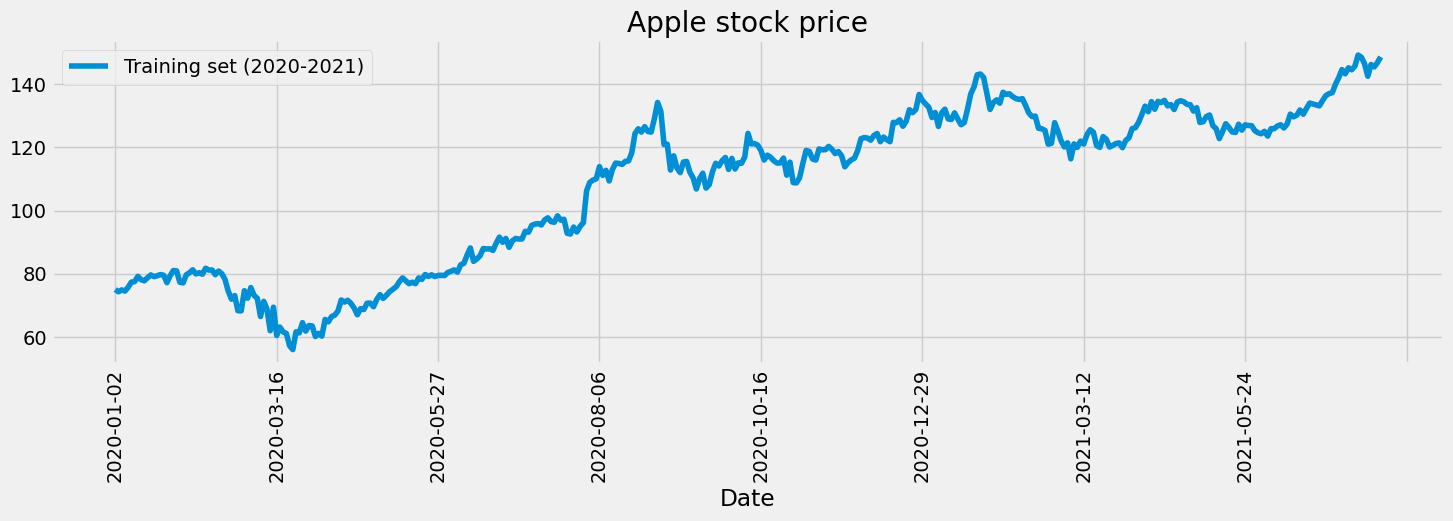

In [6]:
plt.figure(figsize=(10,5))
Data['Close']['2020':'2021-07-25'].plot(figsize=(16,4),legend=True)
plt.xticks(rotation=90)
plt.legend(['Training set (2020-2021)'])
plt.title('Apple stock price')
plt.show()

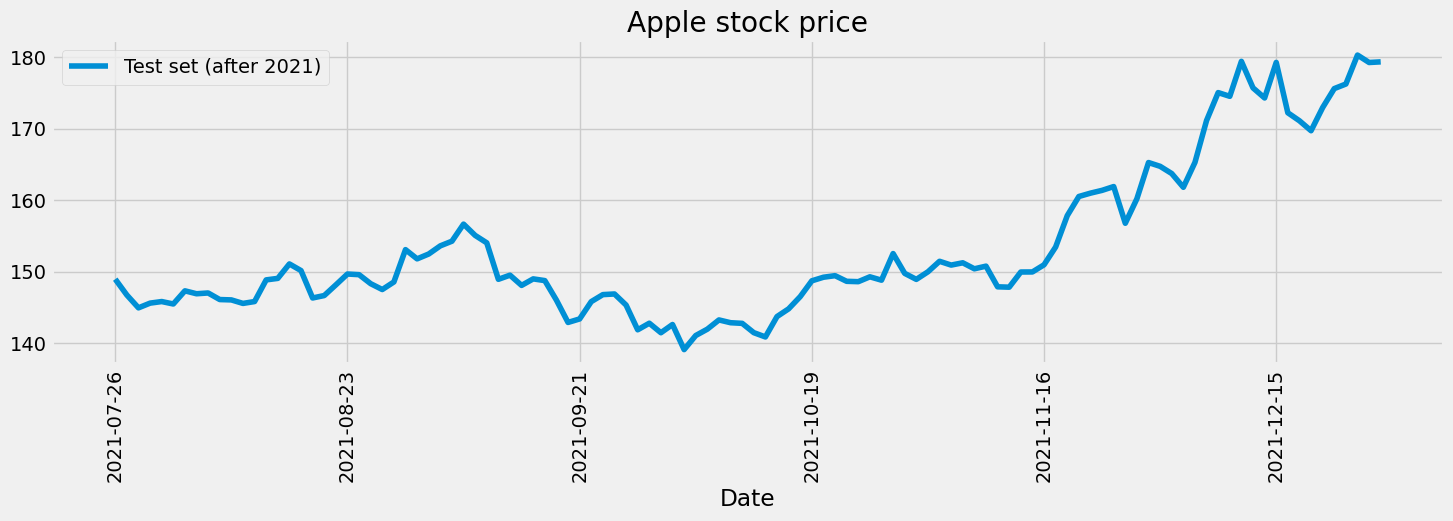

In [7]:
Data['Close']['2021-07-25':].plot(figsize=(16,4),legend=True)
plt.xticks(rotation=90)
plt.legend(['Test set (after 2021)'])
plt.title('Apple stock price')
plt.show()

In [8]:
#Extract High column data
Train_set=Data['Close']['2020-03-10':'2021-07-25'].values
Test_set=Data['Close']['2021-07-25':].values
S=MinMaxScaler()
scaled_train=S.fit_transform(Train_set.reshape(-1,1))
scaled_test=S.transform(Test_set.reshape(-1,1))

**Chuẩn bị dữ liệu để dự đoán trên tập test bằng mô hình Recurrent Neural Network (RNN). Trong đó, RNN hoạt động trên dữ liệu chuỗi, và để dự đoán trên tập test, mô hình cần nhìn thấy dữ liệu từ tập train. Cụ thể, 20 dữ liệu cuối cùng từ tập train sẽ được sử dụng để dự đoán điểm dữ liệu đầu tiên trong tập test.

**Dòng mã scaled_train[-21:] lấy 20 dữ liệu cuối cùng từ tập train, và scaled_test là tập test. Hàm np.concatenate được sử dụng để ghép hai tập dữ liệu này lại với nhau theo trục 0 (axis=0), tức là ghép theo chiều dọc. Kết quả chúng ta nhận được là Test_set_to_prediction, đó là tập dữ liệu đã được chuẩn bị để dự đoán trên tập test.
**

In [9]:
Test_set_to_prediction=np.concatenate([scaled_train[-21:],scaled_test],axis=0)

In [10]:
window_size = 3
def windowed_dataset(series,batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series.reshape(-1,1)) 
    #Đoạn mã này tạo một đối tượng tf.data.Dataset từ chuỗi dữ liệu series. 
    #Hàm from_tensor_slices được sử dụng để chuyển đổi mảng NumPy thành một dataset TensorFlow. 
    #Trước khi tạo dataset, chuỗi dữ liệu được thay đổi hình dạng thành một mảng 2 chiều với chỉ mục thứ hai có kích thước 1. 
    
    
    # Đoạn mã này tạo cửa sổ trượt trên dataset. Cửa sổ có kích thước là window_size + 1. 
    #Cửa sổ trượt lấy các mẫu liên tiếp từ dataset, với bước trượt là 1. 
    #Đối số drop_remainder=True kích thước chính xác là window_size + 1 sẽ được chấp nhận, 
    #các cửa sổ có kích thước nhỏ hơn sẽ bị loại bỏ.
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Kết quả là một dataset chứa các batch dữ liệu có kích thước window_size + 1.
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Đoạn mã này tạo các cặp dữ liệu (features, labels) từ các batch dữ liệu. 
    #Hàm map được gọi trên dataset để áp dụng một hàm lambda cho mỗi batch dữ liệu
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # Create batches of windows
    dataset = dataset.batch(len(series)).prefetch(1)
    
    return dataset

In [11]:
X,y=np.array(list(windowed_dataset(scaled_train,10))[0][0]),np.array(list(windowed_dataset(scaled_train,10))[0][1])
# trích xuất features và labels từ dataset windowed_dataset với cửa sổ kích thước 10 và gán chúng cho các mảng X và y tương ứng.

In [12]:
X_test,y_test=np.array(list(windowed_dataset(Test_set_to_prediction,10))[0][0]),np.array(list(windowed_dataset(Test_set_to_prediction,10))[0][1])
#tạo ra hai mảng X_test và y_test, chứa các mẫu dữ liệu và nhãn tương ứng, từ tập dữ liệu Test_set_to_prediction. Các mảng này sẽ được sử dụng để đánh giá hiệu suất dự đoán của mô hình trên tập dữ liệu kiểm tra.

In [13]:
from keras.layers import Input

Model1 = Sequential()
Model1.add(Input(shape=(X.shape[1], 1)))
Model1.add(LSTM(units=60, return_sequences=True))
Model1.add(LSTM(units=50, return_sequences=True))
Model1.add(LSTM(units=30, return_sequences=True))
Model1.add(LSTM(units=20, return_sequences=True))
Model1.add(LSTM(units=10))
Model1.add(Dense(units=1))

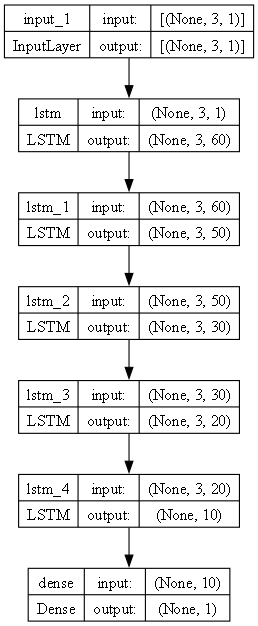

In [14]:
plot_model(Model1, show_shapes = True,expand_nested = True,dpi = 80)

In [15]:
Model1.compile(optimizer = "adam",loss='mean_squared_error')

In [16]:
Model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 60)             14880     
                                                                 
 lstm_1 (LSTM)               (None, 3, 50)             22200     
                                                                 
 lstm_2 (LSTM)               (None, 3, 30)             9720      
                                                                 
 lstm_3 (LSTM)               (None, 3, 20)             4080      
                                                                 
 lstm_4 (LSTM)               (None, 10)                1240      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 52131 (203.64 KB)
Trainable params: 52131 

In [17]:
callbacks=tf.keras.callbacks.ModelCheckpoint(
    'Model.keras',
    monitor= 'loss',
    save_best_only=True)
history=Model1.fit(X,y,epochs=350,callbacks=[callbacks])#350

Epoch 1/350

11/11 [==============================] - 12s 27ms/step - loss: 0.3967
Epoch 2/350
11/11 [==============================] - 0s 18ms/step - loss: 0.3003
Epoch 3/350
11/11 [==============================] - 0s 18ms/step - loss: 0.1385
Epoch 4/350
11/11 [==============================] - 0s 20ms/step - loss: 0.0506
Epoch 5/350
11/11 [==============================] - 0s 17ms/step - loss: 0.0359
Epoch 6/350
11/11 [==============================] - 0s 18ms/step - loss: 0.0328
Epoch 7/350
11/11 [==============================] - 0s 18ms/step - loss: 0.0253
Epoch 8/350
11/11 [==============================] - 0s 20ms/step - loss: 0.0188
Epoch 9/350
11/11 [==============================] - 0s 16ms/step - loss: 0.0121
Epoch 10/350
11/11 [==============================] - 0s 19ms/step - loss: 0.0072
Epoch 11/350
11/11 [==============================] - 0s 15ms/step - loss: 0.0042
Epoch 12/350
11/11 [==============================] - 0s 19ms/step - loss: 0.0030
Epoch 13/350
11/11 [===

11/11 [==============================] - 0s 10ms/step - loss: 0.0015
Epoch 198/350
11/11 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 199/350
11/11 [==============================] - 0s 9ms/step - loss: 0.0014
Epoch 200/350
11/11 [==============================] - 0s 15ms/step - loss: 0.0014
Epoch 201/350
11/11 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 202/350
11/11 [==============================] - 0s 10ms/step - loss: 0.0014
Epoch 203/350
11/11 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 204/350
11/11 [==============================] - 0s 13ms/step - loss: 0.0015
Epoch 205/350
11/11 [==============================] - 0s 9ms/step - loss: 0.0016
Epoch 206/350
11/11 [==============================] - 0s 9ms/step - loss: 0.0014
Epoch 207/350
11/11 [==============================] - 0s 9ms/step - loss: 0.0014
Epoch 208/350
11/11 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 209/350
11/11 [==

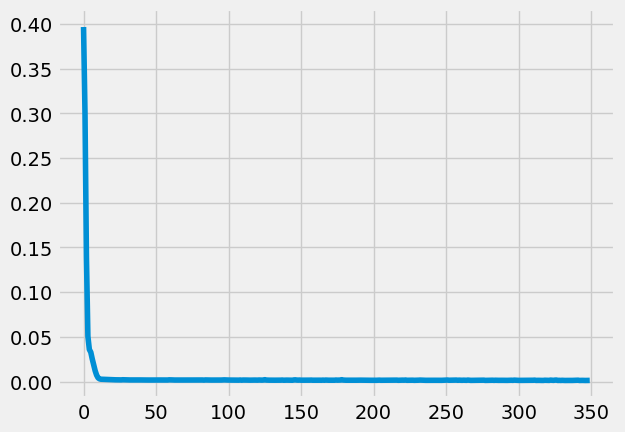

In [18]:
plt.plot(history.history['loss'])

In [19]:
Output1=Model1.predict(X_test)

4/4 [==============================] - 2s 6ms/step


In [20]:
Model1.evaluate(y_test,Output1)

4/4 [==============================] - 2s 4ms/step - loss: 0.7159


0.7158801555633545

In [21]:
mean_squared_error(S.inverse_transform(y_test),S.inverse_transform(Output1))

19.0872696839752

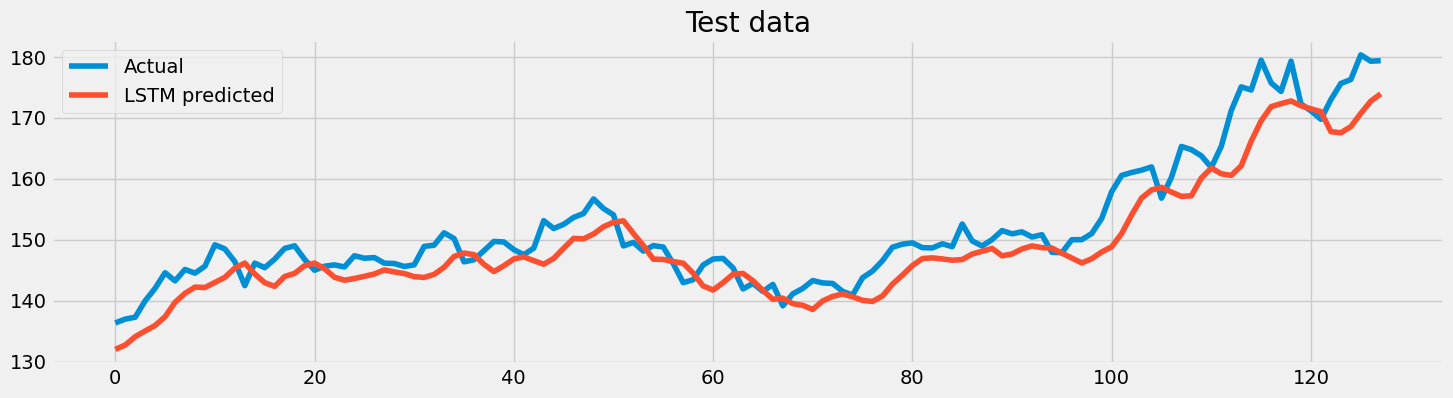

In [22]:
x=np.arange(0,len(y_test))
plt.figure(figsize=(16,4))
plt.title("Test data",fontsize=20)
plt.plot(x,S.inverse_transform(y_test),label="Actual")
plt.plot(x,S.inverse_transform(Output1),label="LSTM predicted")
plt.legend()
plt.show()

In [23]:
Out=Model1.predict(X)

11/11 [==============================] - 2s 4ms/step


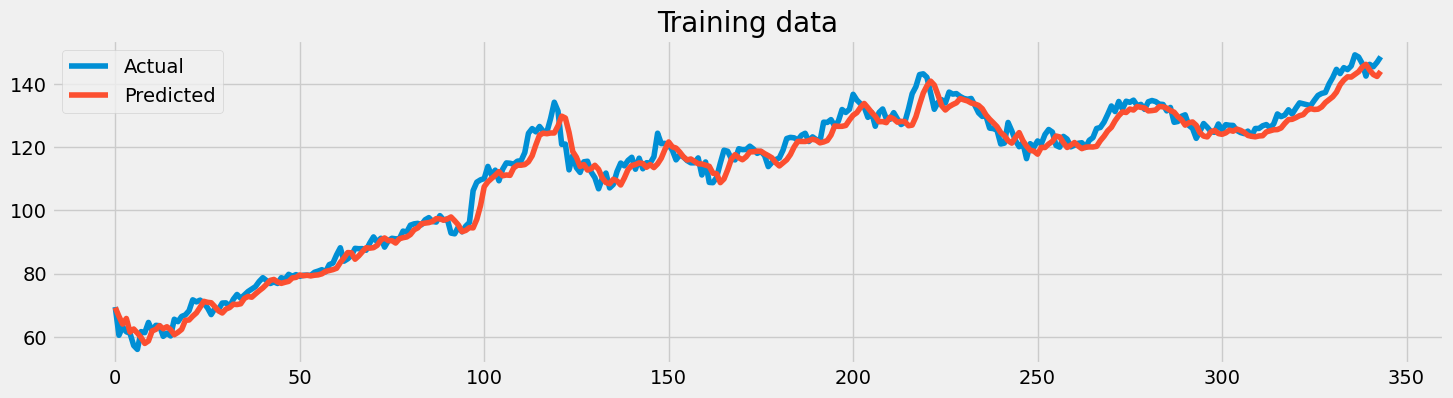

In [24]:
q=np.arange(0,len(y))
plt.figure(figsize=(16,4))
plt.title("Training data",fontsize=20)
plt.plot(q,S.inverse_transform(y),label='Actual')
plt.plot(q,S.inverse_transform(Out),label='Predicted')
plt.legend()
plt.show()

# Simple Dense Layer

In [25]:
Model2=Sequential(
[
    Dense(units=30,input_shape=(X.shape[1],1),activation='relu'),
    Dense(units=20,activation='relu'),
    Dense(units=10),
    Dense(units=1)
])

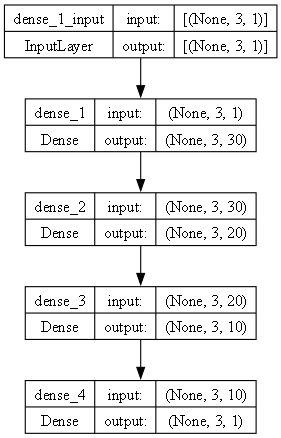

In [26]:
plot_model(Model2, show_shapes = True,expand_nested = True,dpi = 80)

In [27]:
Model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3, 30)             60        
                                                                 
 dense_2 (Dense)             (None, 3, 20)             620       
                                                                 
 dense_3 (Dense)             (None, 3, 10)             210       
                                                                 
 dense_4 (Dense)             (None, 3, 1)              11        
                                                                 
Total params: 901 (3.52 KB)
Trainable params: 901 (3.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
Model2.compile(optimizer='adam',loss='mse')

In [29]:
history2=Model2.fit(X,y,epochs=100,callbacks=[callbacks])

Epoch 1/100
11/11 [==============================] - 1s 2ms/step - loss: 0.2870
Epoch 2/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1107
Epoch 3/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0277
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 5/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 6/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 7/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 8/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 9/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 10/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 11/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 12/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 13/100
11/11 [=================

In [30]:
Output2=Model2.predict(X_test)
l=Output2.shape[0]
a=[]
for i in range(l):
    a.append(Output2[i][0])
a=np.array(a)

4/4 [==============================] - 0s 2ms/step


In [31]:
mean_squared_error(S.inverse_transform(y_test),S.inverse_transform(a.reshape(-1,1))) 

32.77540584601422

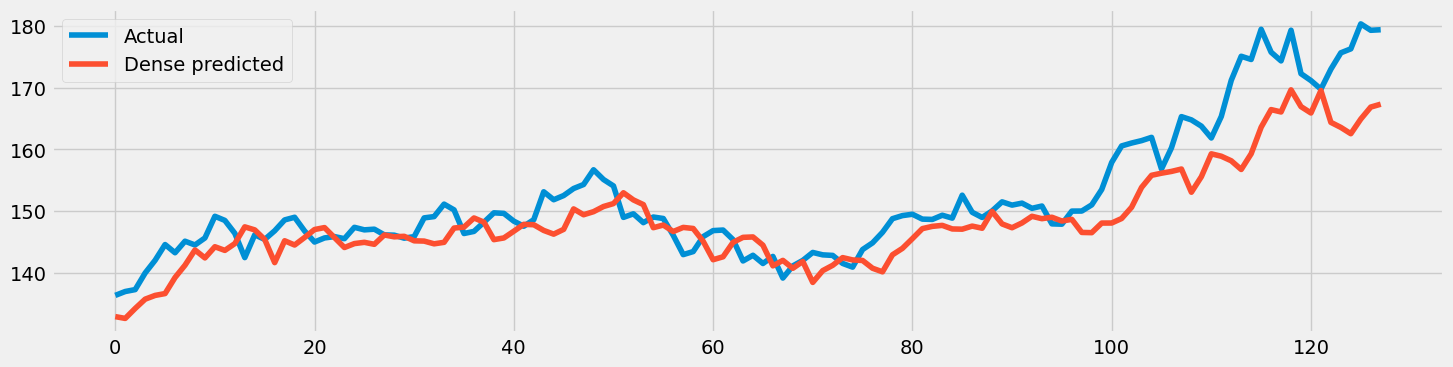

In [35]:
x=np.arange(0,len(y_test))
plt.figure(figsize=(16,4))
plt.plot(x,S.inverse_transform(y_test),label="Actual")
plt.plot(x,S.inverse_transform(a.reshape(-1,1)),label="Dense predicted")
plt.legend()
plt.show()

# So sánh 2 mô hình áp dụng:

In [45]:
# Chuyển đổi Output2 về dạng 1D array
l = Output2.shape[0]
a = []
for i in range(l):
    a.append(Output2[i][0])
a = np.array(a)

# Tính các thông số so sánh
mse1 = mean_squared_error(S.inverse_transform(y_test), S.inverse_transform(Output1))
mse2 = mean_squared_error(S.inverse_transform(y_test), S.inverse_transform(a.reshape(-1,1)))

rmse1 = np.sqrt(mse1)
rmse2 = np.sqrt(mse2)

r2_1 = r2_score(S.inverse_transform(y_test), S.inverse_transform(Output1)) 
r2_2 = r2_score(S.inverse_transform(y_test), S.inverse_transform(a.reshape(-1,1)))

mae1 = mean_absolute_error(S.inverse_transform(y_test), S.inverse_transform(Output1))
mae2 = mean_absolute_error(S.inverse_transform(y_test), S.inverse_transform(a.reshape(-1,1)))

print("Model LSTM:")
print(f"MSE: {mse1:.3f}")
print(f"RMSE: {rmse1:.3f}")
print(f"R-squared: {r2_1:.3f}")
print(f"MAE: {mae1:.3f}")

print("\nModel Simple Dense Layer :")
print(f"MSE: {mse2:.3f}")
print(f"RMSE: {rmse2:.3f}")
print(f"R-squared: {r2_2:.3f}")
print(f"MAE: {mae2:.3f}")


Model LSTM:
MSE: 19.087
RMSE: 4.369
R-squared: 0.827
MAE: 3.583

Model Simple Dense Layer :
MSE: 32.775
RMSE: 5.725
R-squared: 0.704
MAE: 4.292


| Model   | MSE      | MAE      | R2 Score | RMSE  |
|---------|----------|----------|----------|--------|
| LTSM | 19.087 | 3.583 | 0.9996985644983746 |4.369|
| Dense Layer | 32.775 | 4.292 | 0.9999912056936733 |5.725|

## Khi so sánh 2 mô hình này, ta có thể thấy rằng:

++ MSE và RMSE của Model LSTM thấp hơn so với Model Simple Dense Layer, điều này chỉ ra rằng Model LSTM có độ lỗi trung bình thấp hơn, có nghĩa là dự đoán của nó gần với giá trị thực tế hơn.

++ Giá trị R-squared của Model LSTM là 0.827, cao hơn so với 0.704 của Model Simple Dense Layer. R-squared là một chỉ số đánh giá mức độ phù hợp của mô hình, giá trị càng cao (gần 1) thì mô hình càng tốt. Vì vậy, Model LSTM có khả năng giải thích và dự đoán tốt hơn so với Model Simple Dense Layer.

++ MAE của Model LSTM là 3.583, thấp hơn so với 4.292 của Model Simple Dense Layer. MAE đo lường độ lệch trung bình tuyệt đối giữa giá trị dự đoán và giá trị thực tế, do đó, Model LSTM có độ chính xác cao hơn.


# Kết luận:
Dựa trên các chỉ số đánh giá, Model LSTM có hiệu suất tốt hơn so với Model Simple Dense Layer. 
Mô hình LSTM thể hiện khả năng dự đoán và giải thích cao hơn, với độ lỗi trung bình thấp hơn và độ chính xác cao hơn. 
Do đó, có thể kết luận rằng Model LSTM là mô hình tốt hơn để giải quyết bài toán này.